# CS 1674/2074: Assignment 6

Please, follow the instructions below:

**FUNCTIONS PROVIDED TO STUDENTS**

In [6]:
import cv2
import os
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

### FUNCTIONS PROVIDED TO STUDENTS ###

def dist_sqr(x,y):
    d, n = x.shape
    d, m = y.shape

    z    = x.T @ y
    x_2  = np.sum(x**2,0)[:,np.newaxis]
    y_2  = np.sum(y**2,0)[np.newaxis,:]

    for i in range(m):
        r = (x_2 + y_2[:,i] - 2*z[:,i][:,np.newaxis])
        z[:,i] = r.reshape(-1)

    return z

def eff_dist_sqr (O00000000OO0OO0O0 ,O0000OO0OOO00OO00 ):#line:1
    OO00OO00000000OO0 ,O0OO000OO000OO00O =O00000000OO0OO0O0 .shape #line:2
    O0O0OO0O0OO00OOO0 ,O0OO000OO000OO00O =O0000OO0OOO00OO00 .shape #line:3
    OO00O0O0O0O0OOO0O =(np .ones ((O0O0OO0O0OO00OOO0 ,1 ))@np .sum ((O00000000OO0OO0O0 **2 ).T ,0 )[np .newaxis ,:]).T +np .ones ((OO00OO00000000OO0 ,1 ))@np .sum ((O0000OO0OOO00OO00 **2 ).T ,0 )[np .newaxis ,:]-2 *(O00000000OO0OO0O0 @O0000OO0OOO00OO00 .T )#line:5
    OO00O0O0O0O0OOO0O =np .where (OO00O0O0O0O0OOO0O <0 ,0 ,OO00O0O0O0O0OOO0O )#line:6
    return OO00O0O0O0O0OOO0O #line:8
    
def compute_BOW_repr (OO0OOOO0O00O000OO ,O0OOO0OO0O000OOO0 ):#line:10
    OO0OOOO0O00O000OO =np .array (OO0OOOO0O00O000OO )#line:11
    O0O0OOOO00OOO0000 =O0OOO0OO0O000OOO0 .shape [0 ]#line:13
    O0O00O0O0OO0000OO =np .zeros ((1 ,O0O0OOOO00OOO0000 ))#line:14
    if OO0OOOO0O00O000OO .shape [0 ]==0 :#line:16
        return O0O00O0O0OO0000OO #line:17
    if OO0OOOO0O00O000OO .shape [1 ]<O0OOO0OO0O000OOO0 .shape [1 ]:#line:19
        return O0O00O0O0OO0000OO #line:20
    OOO00OOO0OOO000OO =eff_dist_sqr (OO0OOOO0O00O000OO ,O0OOO0OO0O000OOO0 )#line:22
    O0OOO0O00000O0O0O =np .argmin (OOO00OOO0OOO000OO ,1 )#line:24
    for O00OO0O0000O0O0OO in range (O0O0OOOO00OOO0000 ):#line:26
        O0O00O0O0OO0000OO [:,O00OO0O0000O0O0OO ]=np .sum (O0OOO0O00000O0O0O ==O00OO0O0000O0O0OO )#line:27
    O0O00O0O0OO0000OO =O0O00O0O0OO0000OO /np .sum (O0O00O0O0OO0000OO )#line:29
    return O0O00O0O0OO0000OO 

def load_split_dataset():
    path = 'scenes_lazebnik/'

    sift = cv2.SIFT_create(nfeatures=200)
    all_scenes = os.listdir(path)

    all_images = []
    all_sift = []
    all_labels = []
    all_train_ids = []
    all_test_ids = []
    
    for i in range(len(all_scenes)):
        scene_entry = all_scenes[i]
        scene_dir   = path + scene_entry
        data_for_this_scene = [dirx for dirx in os.listdir(scene_dir) if dirx.endswith('.jpg') ]
        this_cat_sift   = []
        this_cat_images = []

        for j in range(len(data_for_this_scene)):
            this_file = data_for_this_scene[j]
            img_path  = scene_dir + '/' + this_file 
            img       = cv2.imread(img_path, 0)#.astype(np.float32)
            this_cat_images.append(img)

        r = np.random.permutation(len(this_cat_images))[0:75]
        this_cat_images = [this_cat_images[i] for i in r]
        this_cat_sift   = [sift.detectAndCompute(img, None) for img in this_cat_images]

        r = np.random.permutation(len(this_cat_images))

        train_ids = len(all_labels) + r[0:50]
        test_ids  = len(all_labels) + r[50:75]

        all_train_ids.extend(train_ids)
        all_test_ids.extend(test_ids)

        all_labels.extend([i] * len(this_cat_images))
        all_sift.extend(this_cat_sift)
        all_images.extend(this_cat_images)

    train_images = [ all_images[i] for i in all_train_ids]
    train_sift   = [ all_sift[i] for i in all_train_ids]
    train_labels = [ all_labels[i] for i in all_train_ids]
    test_images  = [ all_images[i] for i in all_test_ids]
    test_sift    = [ all_sift[i] for i in all_test_ids]
    test_labels  = [ all_labels[i] for i in all_test_ids]

    means = np.loadtxt('means.out')
    return train_images, train_sift, train_labels, test_images, test_sift, test_labels, means

In this assignment, you will develop two variants of a scene categorization system. You will write five functions. The first function will compute the spatial pyramid match representation. The second and third will find labels for your test images, using two classifiers: K nearest neighbors (KNN), and support vector machines (SVM). For the last two functions, you will call your first function to compute the SPM representation, then compare the performance of different levels of the SPM representation, and different classifiers. **Please read the entire assignment before start working.**

Download the images and SIFT features (we won't use .mat files, SIFT features are generated by code) contained in the `scenes_lazebnik.zip` file from [here](https://sites.pitt.edu/~nem177/courses/fall24_cs1674/scenes_lazebnik.zip). This file contains the dataset split across eight folders, for eight classes/categories. All images in a subfolder (e.g. "coast") belong to the same category. For each sample, the dataset includes the image, a resized image (to be used in a later assignment).

Next, run `load_split_dataset()` function from Github repo. This function is the first thing you should run. It assigns the following variables:

* `train_images`(matrix of size *M* where *M* is the total number of training images; it contains the matrix for each training image, which you need for the spatial pyramid representation). 
* `train_sift` (a tuple of a array of Keypoints (cv2.Keypoints - .pt[0]; .pt[1]) and matrix of descriptors of size *M*x128)
* `train_labels` (vector of size *M*, containing the labels for each training image),
* `test_images` (matrix of size *N*, where *N* is the total number of test images),
* `test_sift` (a tuple of a array of Keypoints (cv2.Keypoints - .pt[0]; .pt[1]) and matrix of descriptors of size *M*x128),
* `test_labels` (vector of size *N*).



There are 75 images total for each class, and this script splits them into 50 per class for training, and 25 for test. It also runs K-means to obtain a means variable (of size KxD, where K is the number of clusters and D is the feature dimensionality, explained before) which you will need. You will get a warning that K-means failed to converge-- that's ok; we can ask it to run for more iterations, but for expediency, we won't.

For each image, the corresponding feature variables ( train_sift or test_sift ) is a list of image features. Each row contains: f (position 0) and d (position 1). You need the first two entries of `f` to determine the (x, y) coordinates of the descriptor  `d`. 

While the `load_split_dataset` function loads the SIFT descriptors, the features we will actually use to classify aggregate all SIFT descriptors per image. You will do this in `compute_SPM_repr`, and use this representation in your `compare_representations` and `compare_classifiers` functions, explained below. 

## Part I: Computing the SPM representation (20 points)

The Spatial Pyramid Match (SPM) representation was proposed in 2006 by Svetlana Lazebnik, Cordelia Schmid and Jean Ponce, and won the "test of time" award at CVPR 2016. The procedure of computing the pyramid is summarized in the following image from the paper, and described below. You will only construct the first two levels (level-0 and level-1).

![title](images/spm.jpg)

Write the following function: `def compute_SPM_repr(img, features, means)` return `pyramid`, `level_0`, `level_1`; which computes the Spatial Pyramid Match histogram as described in class.

Inputs:
* `img`, contain the image matrix.
* `features` are the SIFT features for the image, and
* `means` are the cluster centers from the bag-of-visual-words clustering operation (loaded on the training images in load_split_dataset).

Outputs:

* `pyramid` is a 1x*D* feature descriptor for the image concatenating the level-0 and level-1 of the spatial pyramid match representation.
* `level_0` is the standard bag-of-words histogram, and
* `level_1` is the bag-of-words histogram at level-1 (i.e. one histogram for each quadrant of the image).
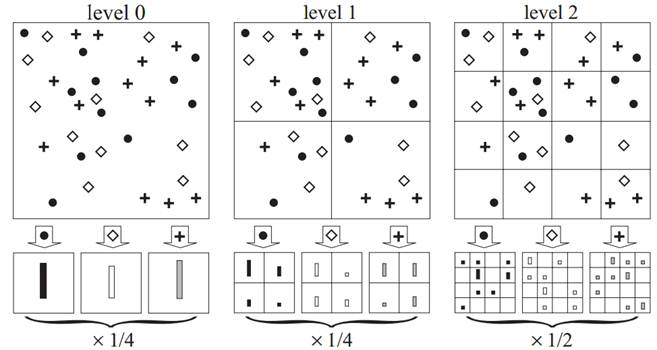

Instructions:

1.  [4 pts] First, create a "bag of words" histogram representation of the features in the image, using the function `def compute_BOW_repr(descriptors, means)` return `bow` that you wrote for HW4 (if your function does not work, you can use the one provided on Github). This will give you the representation shown in the left-hand side of the figure above, where the circles, diamonds and crosses denote different "words". In this toy example *K* = 3; in your submission, use *K* = 50. This forms your representation of the image, at level *L* = 0 of the pyramid.
   
3.  [14 pts] Then, divide the image into four quadrants as shown below. You need to know the locations of the feature descriptors so that you know in which quadrant they fall ; these are stored in the f portion of the train_sift and test_sift variables. Compute four BOW histograms, using the compute_BOW_repr function, but generating a separate BOW representation for each quadrant. The concatenation of the four histograms is your level-1 representation of the image. The size of this representation is 1x(4 * *K*).

![title](images/grid1.png)

3. [2 pts] Finally, concatenate the level-0 and level-1 representations computed in the above steps. This will give you the final image representation, and should be saved in the `pyramid` variable.

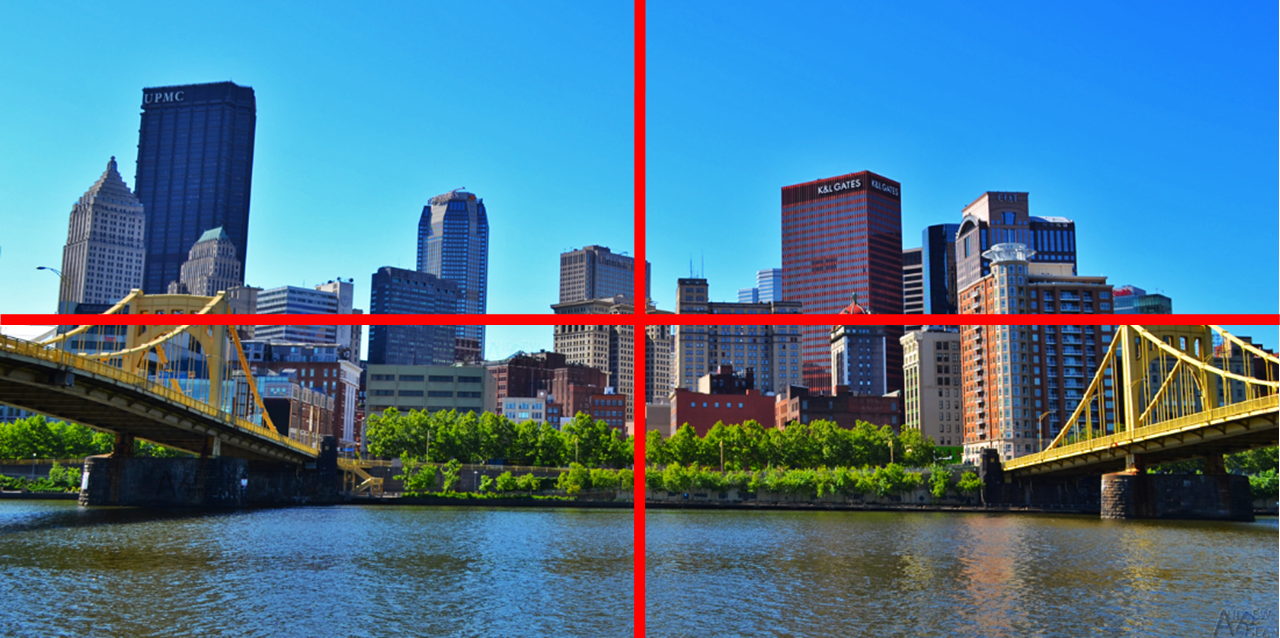

In [22]:
def compute_SPM_repr(img, features, means):
    keypoints, descriptors = features
    
    if not isinstance(descriptors, np.ndarray):
        descriptors = np.array(descriptors)

    level_0 = compute_BOW_repr(descriptors, means)

    level_1 = []
    width = img.shape[1]
    height = img.shape[0]

    quadrants = [
        (0, height // 2, 0, width // 2),  # top left
        (0, height // 2, width // 2, width),  # top right
        (height // 2, height, 0, width // 2),  # bottom left
        (height // 2, height, width // 2, width)  # bottom right
    ]

    for i, (y_min, y_max, x_min, x_max) in enumerate(quadrants):
        quadrant_descriptors = [
            descriptors[j] for j in range(len(keypoints))
            if y_min <= keypoints[j].pt[1] < y_max and x_min <= keypoints[j].pt[0] < x_max
        ]

        if quadrant_descriptors:
            quadrant_hist = compute_BOW_repr(np.array(quadrant_descriptors), means).flatten()
        else:
            quadrant_hist = np.zeros(50)
        level_1.append(quadrant_hist)

    level_1 = np.vstack(level_1)
    pyramid = np.vstack([level_0.reshape(1, 50), level_1])
    
    return pyramid, level_0, level_1


## Part II: Training and obtaining labels from two classifiers (30 points)

In this part, you will write functions to obtain labels on the test data from two classifiers, support vector machines (SVM) and K nearest neighbors (KNN). (We will cycle the training or test sets as the actual test set, for comparison purposes, in Part III below.) Note that the value of *k* in KNN is distinct from the value *K* in K-means; we'll use k to denote the former and *K* to denote the later.

Write the following functions:

1. [20 pts] `def find_labels_KNN(pyramids_train, labels_train, pyramids_test, k)` return `predicted_labels_test`; which predicts the labels of the test images using the KNN classifier. For each test image, compute the Euclidean distance between its descriptor and each training image's descriptor (the descriptors are now the Spatial Pyramids). Then find its k closest neighbors among only training images; you can use `‘eff_dist_sqr’`. Find the mode (most common value) among the labels, and assign the test image to this label. In other words, the neighbors are "voting" on the label of the test image. **You can use KNN from sklearn package [sklearn package](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) for training and testing**.

    Inputs:
    * `pyramids_train` ;, pyramids_test should be an MxD matrix and an NxD, respectively, where M is the size of the training image set, N is the size of your test image set, D equals 5*K, and each pyramids[i, :] is the 1xD Spatial Pyramid Match representation of the corresponding training or test image.
    * `labels_train` should be an Mx1 vector of training labels.
    * `k` is the number of neighbors.

    Outputs:
    
    * `predicted_labels_test` should be a Nx1 vector of predicted labels for the test images.
  


2. [10 pts] `def find_labels_SVM(pyramids_train, labels_train, pyramids_test)` return `predicted_labels_test`; which predicts the labels of the test images using an SVM. This function should include training the SVM. The inputs and outputs are defined as above but now we will use an SVM to determine the outputs. **You can use SVM from [sklearn package](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) for training and testing**. You can use a linear kernel.




In [2]:
from sklearn.neighbors import KNeighborsClassifier

def find_labels_KNN(pyramids_train, labels_train, pyramids_test, k):
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(pyramids_train, labels_train)
    predicted_labels_test = knn.predict(pyramids_test)
    return predicted_labels_test

def find_labels_SVM(pyramids_train, labels_train, pyramids_test):
    svm = SVC(kernel='linear')
    svm.fit(pyramids_train, labels_train)
    predicted_labels_test = svm.predict(pyramids_test)
    return predicted_labels_test

## Part III: Comparing approaches (50 pts)

In this part, you will compare the KNN and SVM classifiers using the SPM representation. You will also compare how the same classifier performs when it uses different levels of the SPM pyramid. Your classifiers will predict to which scene category each test image belongs.


1. [20 pts] In `def compare_representation(train_images, train_sift, train_labels, test_images, test_sift, test_labels, means)`:

    * [10 pts] Call your compute_SPM_repr to compute the spatial pyramid match representation on top of the extracted SIFT features, for all train/test images. Store the resulting representations (level-0, level-1, and pyramid separately) in appropriate variables (with rows corresponding to number of samples, and columns corresponding to feature dimensions).
    * [10 pts] Use an SVM classifier. Compare the quality of three representations, pyramid, level_0 and level_1. In other words, compare the full SPM representation to its constituent parts, which are the level-0 histogram and the concatenations of four histograms in level-1. Compute the accuracy at each level, by measuring what fraction of the images was assigned the correct label. In a file results1.txt, describe your findings, and give your explanation of the performance of the different representations.

2. [30 pts] In a function `def compare_classifiers(train_images, train_sift, train_labels, test_images, test_sift, test_labels, means)`, do the following steps (you can interleave them as you wish, order does not have to be as shown). You can assume the previous script has been run first, so you don't have to recompute the SPM representations.
    * [10 pts] Apply the SVM and KNN classifiers (i.e. call find_labels_SVM, find_labels_KNN) to predict labels on the test set, using the pyramid variable as the representation for each image. For KNN, use the following values of k in [1, 5, 25].
    * [4 pts] Compute the accuracy of each classifier on (1) the training set, and (2) the test set, by comparing its predictions with the "ground truth" labels.
    * [10 pts] Plot the training and test accuracy of both types of classifiers, using the values of k on the x-axis, and accuracy on the y-axis. Since SVM does not depend on the value of k, plot its performance as a straight line. Save the result as results.png and add to your Github repo. Label your axes and show a legend. Some useful functions are: plot, xlabel, ylabel, and legend.
    * [6 pts] Finally, in a text file results2.txt, explain what you see in your plot, and explain the trends on the training and test sets you see as k increases.



In [37]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

def compare_representation(train_images, train_sift, train_labels, test_images, test_sift, test_labels, means):
    train_level_0, train_level_1, train_pyramid = [], [], []
    test_level_0, test_level_1, test_pyramid = [], [], []
    
    for img, sift in zip(train_images, train_sift): #for each image, compute SPM and append to training array
        pyramid, lev0, lev1 = compute_SPM_repr(img, sift, means)
        train_level_0.append(lev0.flatten())
        train_level_1.append(lev1.flatten())
        train_pyramid.append(pyramid.flatten())
    
    for img, sift in zip(test_images, test_sift): #for each image, compute SPM and append to testing array
        pyramid, lev0, lev1 = compute_SPM_repr(img, sift, means)
        test_level_0.append(lev0.flatten())
        test_level_1.append(lev1.flatten())
        test_pyramid.append(pyramid.flatten())
    
    train_level_0 = np.array(train_level_0) #convert to array for training
    train_level_1 = np.array(train_level_1)
    train_pyramid = np.array(train_pyramid)
    test_level_0 = np.array(test_level_0)
    test_level_1 = np.array(test_level_1)
    test_pyramid = np.array(test_pyramid)
    
    #train and test data and find accuracy
    svm = SVC(kernel='linear')
    
    svm.fit(train_level_0, train_labels)
    pred_test_level_0 = svm.predict(test_level_0)
    accuracy_level_0 = accuracy_score(test_labels, pred_test_level_0)
    
    svm.fit(train_level_1, train_labels)
    pred_test_level_1 = svm.predict(test_level_1)
    accuracy_level_1 = accuracy_score(test_labels, pred_test_level_1)
    
    svm.fit(train_pyramid, train_labels)
    pred_test_pyramid = svm.predict(test_pyramid)
    accuracy_pyramid = accuracy_score(test_labels, pred_test_pyramid)
    return accuracy_level_0, accuracy_level_1, accuracy_pyramid




def compare_classifiers(train_images, train_sift, train_labels, test_images, test_sift, test_labels, means):
    train_pyramid = [compute_SPM_repr(img, sift, means)[2].flatten() for img, sift in zip(train_images, train_sift)]
    test_pyramid = [compute_SPM_repr(img, sift, means)[2].flatten() for img, sift in zip(test_images, test_sift)]
    train_pyramid, test_pyramid = np.array(train_pyramid), np.array(test_pyramid)
    
    k_values = [1, 5, 25] #set values for k
    knn_train_accuracies = []
    knn_test_accuracies = []
    
    for k in k_values: #train according to KNN 
        knn_train_predictions = find_labels_KNN(train_pyramid, train_labels, train_pyramid, k) 
        knn_test_predictions = find_labels_KNN(train_pyramid, train_labels, test_pyramid, k)

        train_acc = accuracy_score(train_labels, knn_train_predictions)
        test_acc = accuracy_score(test_labels, knn_test_predictions)
        
        knn_train_accuracies.append(train_acc)
        knn_test_accuracies.append(test_acc)
    
    #train according to SVM
    svm_train_predictions = find_labels_SVM(train_pyramid, train_labels, train_pyramid)
    svm_test_predictions = find_labels_SVM(train_pyramid, train_labels, test_pyramid)
    svm_train_acc = accuracy_score(train_labels, svm_train_predictions)
    svm_test_acc = accuracy_score(test_labels, svm_test_predictions)
    
    #create plot and save in results.png
    plt.figure()
    plt.plot(k_values, knn_train_accuracies, label='KNN Train Accuracy', marker='o')
    plt.plot(k_values, knn_test_accuracies, label='KNN Test Accuracy', marker='o')
    plt.axhline(y=svm_train_acc, color='r', linestyle='-', label='SVM Train Accuracy')
    plt.axhline(y=svm_test_acc, color='g', linestyle='-', label='SVM Test Accuracy')
    plt.xlabel("k (for KNN)")
    plt.ylabel("Accuracy")
    plt.title("Comparison of KNN and SVM Accuracies")
    plt.legend()
    plt.savefig("results.png")

## Submission:

Update on Github repo.

    Function computeSPMRepr
    Function findLabelsKNN
    Function findLabelsSVM
    Function compare_representations
    Function compare_classifiers
    Files results.png, results1.txt, results2.txt


## Only for Graders

This space will be used to test your code.

0.444 0.452 0.484


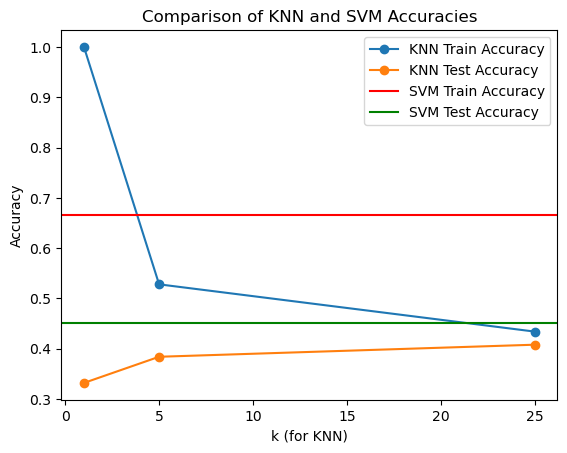

In [39]:
train_images, train_sift, train_labels, test_images, test_sift, test_labels, means = load_split_dataset()
compare_representation(train_images, train_sift, train_labels, test_images, test_sift, test_labels, means)
compare_classifiers(train_images, train_sift, train_labels, test_images, test_sift, test_labels, means)